# Challenge 2: Prototype Learning

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from pathlib import Path
import torchvision
# Path to the training image file
image_path = '/home/julian/data/eth/ml4h/project1/chest_xray'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
import cv2

In [3]:
# Define path to the data directory
data_dir = Path(image_path)

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [4]:
# Get the path to the normal and pneumonia sub-directories
def create_df(path):
    normal_cases_dir = path / 'NORMAL'
    pneumonia_cases_dir = path / 'PNEUMONIA'

    # Get the list of all the images
    normal_cases = normal_cases_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

    # An empty list. We will insert the data into this list in (img_path, label) format
    train_data = []

    # Go through all the normal cases. The label for these cases will be 0
    for img in normal_cases:
        train_data.append((str(img),0))

    # Go through all the pneumonia cases. The label for these cases will be 1
    for img in pneumonia_cases:
        train_data.append((str(img), 1))

    # Get a pandas dataframe from the data we have in our list 
    train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

    # Shuffle the data 
    train_data = train_data.sample(frac=1.).reset_index(drop=True)
    return train_data

# How the dataframe looks like?
train_data = create_df(train_dir)
train_data.head()

,image,label
0,/home/julian/data/eth/ml4h/project1/chest_xray...,1
1,/home/julian/data/eth/ml4h/project1/chest_xray...,1
2,/home/julian/data/eth/ml4h/project1/chest_xray...,0
3,/home/julian/data/eth/ml4h/project1/chest_xray...,1
4,/home/julian/data/eth/ml4h/project1/chest_xray...,0


In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import rbf_kernel, pairwise_distances_argmin
from functools import partial
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import torch
from torchvision import transforms
from PIL import Image
import pandas as pd
import time
from sklearn.model_selection import StratifiedKFold
from itertools import product
from collections import defaultdict
from tqdm import tqdm, trange
import multiprocessing as mp

In [7]:
def plot_img(img):
    if len(img.shape) == 3:
        img = np.transpose(img,(1,2,0))
    img = Image.fromarray(img.astype('uint8'))
    return plt.imshow(img)

def to_gray_scale(img):
    img = img[0]*0.299 + img[1]*0.587 + img[2]*0.114
    return img

def flatten(img):
    return img.reshape(img.shape[0]*img.shape[1])

def inflate(img, img_size=224):
    return img.reshape((img_size, img_size))

In [290]:
class FlattenedDataset(torch.utils.data.Dataset):
    def __init__(self, df, img_size=224, transform=None):
        self.df = df
        self.img_size = img_size
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.df.loc[index, 'image']
        label = self.df.loc[index, 'label']
        img = cv2.imread(image_path)
        if img.shape[2] == 1:
            img = np.dstack([img, img, img])
        
        if self.transform:
            img = self.transform(img)
        img = np.transpose(img,(2,0,1))
        img = img.astype(np.float32)
        # grayscale
        img = to_gray_scale(img)
        
        # resize
        img = cv2.resize(img,(self.img_size,self.img_size))
        
        # flatten
        img = flatten(img)
        return img, label
    
    def __len__(self):
        return len(self.df)
    
    def to_dense(self, indices = None):
        X, Y = [], []
        iterator = range(len(self)) if indices is None else indices
        for idx in iterator:
            x, y = self[idx]
            X.append(x)
            Y.append(y)
        return np.stack(X), np.stack(Y)

def evaluate(Y_true, Y_pred, verbose=True):
    stats = {
        "p": precision_score(Y_true, Y_pred),
        "r": recall_score(Y_true, Y_pred),
        "f1": f1_score(Y_true, Y_pred), 
        "a": accuracy_score(Y_true, Y_pred), 
        "ba": balanced_accuracy_score(Y_true,Y_pred)
    }
    if verbose:
        print(f'Precision/Recall: {round(stats["p"], 2)}/{round(stats["r"],2)}')
        print("F1: ", round(stats["f1"],2))
        print("Acc.:", round(stats["a"],2))
        print("Balanced Acc.:", round(stats["ba"],2))
    return stats

    

In [292]:
df_train = create_df(train_dir)
df_val = create_df(val_dir)
df_test = create_df(test_dir)
train_dataset = FlattenedDataset(df_train, img_size=128)
val_dataset = FlattenedDataset(df_val, img_size=128)
test_dataset = FlattenedDataset(df_test, img_size=128)

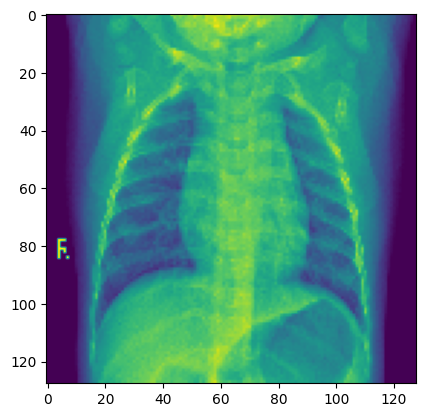

In [299]:
# plot a random image
plot_img(inflate(train_dataset[0][0], img_size=128))

In [300]:
Xval, Yval = val_dataset.to_dense()
Xtest, Ytest = test_dataset.to_dense()
Xtrain, Ytrain = train_dataset.to_dense()

In [157]:
# Hyperparameter space
gamma_candidates = np.array([1e-5, 5e-6, 1e-6, 5e-7, 1e-7, 5e-8, 1e-8, 5e-9, 1e-9])
m_stars = [4, 8, 16, 32, 64, 128, 256, 512, 1024]

## Random S

We define the base version of the RBFNeighborClassifier. It implements 1NN based on the rbf kernel and a given set S.

In [301]:
class RBFNeighborClassifier:
    def __init__(self, gamma):
        self.gamma = gamma
    
    def _rbf(self, x, y):
        if len(x.shape)==1:
            x = x.reshape(1,-1)
        if len(y.shape)==1:
            y = y.reshape(1,-1)
        return -rbf_kernel(x,y,self.gamma)
    
    def __call__(self, X):
        pairwise_distances = self._rbf(X, self.SX)
        predictions = self.SY[pairwise_distances.argmin(axis=1)]
        return predictions
    
    def fit(self, SX, SY):
        self.SX = SX
        self.SY = SY
        
    def score(self, X, Y, verbose=False):
        pred = self(X)
        return evaluate(Y, pred, verbose)

In [302]:
def collect_results(results):
    best = defaultdict(lambda: (0, None))
    for comb in results:
        for key in results[comb]:
            mean = np.array(results[comb][key]).mean()
            if mean > best[key][0]:
                best[key] = (mean, comb)
    return best

### Hyperparameter Search

We implement a hyperparameter grid search to determine the optimal gamma value for the rbf function. 

In [ ]:
# SINGLE PROCESS GRID SEARCH
# It is recommended to run this in parallel as it is very slow
# we run cross validation for m_star=128 and for each fold we sample 5 different S

verbose=1
cv = StratifiedKFold(n_splits=5)
results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for i, (train_index, test_index) in enumerate(cv.split(Xtrain, Ytrain)): 
    for _ in trange(5, desc=f"Fold {i+1}/5", position=0, disable=verbose<1):
        for m_star in [128]:
            S_indices = np.random.choice(len(train_index), m_star, replace=False)
            SX, SY = Xtrain[train_index[S_indices]], Ytrain[train_index[S_indices]] 
            for gamma in tqdm(gamma_candidates, position=1, disable=verbose<2): 
                model = RBFNeighborClassifier(gamma)
                model.fit(SX, SY)
                stats = model.score(Xtrain[test_index], Ytrain[test_index])
                for key in stats:
                    results[m_star][(gamma)][key].append(stats[key])
best = {}
for key in results:
    best[key] = collect_results(results[key])

In [305]:
# MULTIPROCESS GRID SEARCH
# We run cross validation for m_star=128 and for each fold we sample 5 different S

def train_eval(X, Y, S_index, test_index, gamma, m_star, j):
    SX, SY = X[S_index], Y[S_index]
    Xtest, Ytest = X[test_index], Y[test_index]
    model = RBFNeighborClassifier(gamma)
    model.fit(SX, SY)
    stats = model.score(Xtest, Ytest)
    print(j)
    return gamma, m_star, stats

print("Preparing configs")
cv = StratifiedKFold(n_splits=5)
results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
configs = []
j = 0
for i, (train_index, test_index) in enumerate(cv.split(Xtrain, Ytrain)): 
    for _ in trange(5, desc=f"Fold {i+1}/5", position=0):
        for m_star in [128]:
            S_indices = np.random.choice(len(train_index), m_star, replace=False)
            SX, SY = Xtrain[train_index[S_indices]], Ytrain[train_index[S_indices]] 
            for gamma in gamma_candidates: 
                configs.append((Xtrain, Ytrain, S_indices, test_index, gamma, m_star, j))
                j += 1

Preparing configs


Fold 5/5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 884.05it/s]


In [ ]:
print("Starting compute pool")
with mp.Pool(processes=mp.cpu_count()) as pool:
    for i, (gamma, m_star, stats) in enumerate(pool.starmap(train_eval, configs)):
        print(f"Received {i+1}/{len(configs)}")
        for key in stats:
            results[m_star][(gamma)][key].append(stats[key])

In [310]:
best = {}
for key in results:
    best[key] = collect_results(results[key])
best_gamma = best[128]["f1"][1]
print(f"Best gamma: {best_gamma}")
# Best gamma: 1e-06

Best gamma: 1e-06


### Testing

In [311]:
# Create test results by sampling 5 different S for each m_star
results_random = {}
for m_star in m_stars:
    results_random[m_star] = defaultdict(list)
    for i in range(5):
        S_indices = np.random.choice(Xtrain.shape[0], m_star, replace=False)
        SX, SY = Xtrain[S_indices], Ytrain[S_indices]   
        model = RBFNeighborClassifier(best_gamma)
        model.fit(SX, SY)
        stats = model.score(Xtest, Ytest, verbose=False)
        for key in stats:
            results_random[m_star][key].append(stats[key])

In [312]:
f1_scores_random = []
ba_scores_random = []
for m_star in m_stars:
    f1_scores_random.append(np.array(results_random[m_star]['f1']).mean())
    ba_scores_random.append(np.array(results_random[m_star]['ba']).mean())

## MMD for Prototype Selection

Next we define the MMD algorithm for prototype selection. We implement multiple versions of the Jb function. The final MMDPrototypeClassifier class will use the jb_batch_precomputed function that leverages precomputed kernel matrices and computes the score for all candidates at the same time. This brings significant speedups and allows us to search a larger hyperparameter space.

In [318]:
def mmd2(X, Z, kernel):
    n = X.shape[0]
    m = Z.shape[0]
    Xdsum = kernel(X, X).sum()
    Zdsum = kernel(Z, Z).sum()
    XZdsum = kernel(X, Z).sum()
    return Xdsum/n**2 - (2*XZdsum)/(n*m) + Zdsum / m**2

def jb(X, S, kernel):
    n = X.shape[0]
    m = S.shape[0]
    XSdsum = kernel(X, S).sum()
    Sdsum = kernel(S, S).sum()
    return (2*XSdsum)/(n*m) - Sdsum/m**2

def jb_precomputed(XSsum, SSsum):
    """Leverages precomputed kernel matrices. """
    n, m = XSsum.shape
    return (2*XSsum.sum())/(n*m) - SSsum.sum()/m**2

def jb_batch(X, S, candidate_indices, kernel):
    """Optimises Jb function to compute all candidates for new S members at once."""
    n = X.shape[0]
    m = S.shape[0] + 1
    candidate_sums = np.zeros(len(candidate_indices))
    C = X[candidate_indices]
    XSdsum_base = kernel(X, S).sum() 
    XCdsum = kernel(X, C).sum(axis=0) # can be saved
    Sdsum_base = kernel(S, S).sum() 
    SCdsum = kernel(S, C).sum(axis=0)*2
    CCdsum = (kernel(C, C)*np.eye(len(candidate_sums))).sum(axis=1) # can be saved
    candidate_sums = (2*(XSdsum_base + XCdsum))/(n*m) - (Sdsum_base + SCdsum + CCdsum)/m**2 
    return candidate_sums

def jb_batch_precomputed(S_indices, K):
    """Optimises Jb batch function to leverage a precomputed kernel matrix K. Requires no kernel call and provides significant speedup."""
    n = K.shape[0]
    m = len(S_indices) + 1
    Cmask = np.ones(K.shape[0], bool)
    Cmask[S_indices] = 0
    XSsum = K[:, ~Cmask].sum() if len(S_indices) else 0
    SSsum = K[~Cmask, :][:, ~Cmask].sum() if len(S_indices) else 0
    XCsum = K[:, Cmask].sum(axis=0)
    SCsum = K[~Cmask][:, Cmask].sum(axis=0)*2 if len(S_indices) else 0
    CCsum = (K[Cmask, :][:, Cmask] *np.eye(Cmask.sum())).sum(axis=1)
    return (2*(XSsum + XCsum))/(n*m) - (SSsum + SCsum + CCsum)/m**2, np.ix_(Cmask)

class MMDPrototypeClassifier(RBFNeighborClassifier):
    def __init__(self, gamma, m_star, local=False):
        self.m_star = m_star
        self.local = local
        super().__init__(gamma)
    
    def kernel(self, X, Y):
        return self._rbf(X, Y)
    
    @staticmethod
    def _fit(K, m_star, S_indices, verbose=False):
        pbar = tqdm(desc="|S|", total=m_star, disable=not verbose)
        pbar.update(len(S_indices))
        while len(S_indices) < m_star:
            candidate_scores_raw, candidate_indices = jb_batch_precomputed(S_indices, K)
            # F_S = K[S_indices, S_indices].sum() if len(S_indices) else 0 # can be saved since it is constant for all candidates
            # candidate_scores = candidate_scores_raw - F_S
            best = candidate_scores_raw.argmax()
            S_indices.append(candidate_indices[0][best])
            pbar.update(1)
        return S_indices
        
    def fit(self, X, Y, K=None, verbose=0, seperate=False, S_indices=None):
        """
        Args:
            X: Training features
            Y: Labels
            K: Precomputed kernel matrix
            verbose: Set to 1 if progress should be printed
            seperate: Set to True if S should be computed seperately for true and false labels.
            S_indices: A set of already computed S_indices. Only allowed for seperate=False
        """
        if seperate and self.m_star % 2 != 0:
            raise ValueError("If fitting is seperate m_star needs to be even.")
        if seperate and S_indices is not None:
            print("Warning: Incremental building not supported for seperate mode.")
            S_indices = None
        S_indices = [] if S_indices is None else S_indices
        if K is None:
            K = self._rbf(X, X)
        if self.local:
            locality_mask = (Y == Y[:, np.newaxis]).astype(bool)
            K[locality_mask] = 0
            
        if seperate:
            Ymask = Y.astype(bool)
            K_1 = K[Ymask][:, Ymask]
            K_0 = K[~Ymask][:,~Ymask]
            I_1 = np.ix_(Ymask)[0]
            I_0 = np.ix_(~Ymask)[0]
            self.S_indices = [I_0[idx] for idx in MMDPrototypeClassifier._fit(K_0, self.m_star/2, [], verbose)] + [I_1[idx] for idx in MMDPrototypeClassifier._fit(K_1, self.m_star/2, [], verbose)]
        else:
            self.S_indices = MMDPrototypeClassifier._fit(K, self.m_star, S_indices, verbose)
        super().fit(X[self.S_indices], Y[self.S_indices])

In [319]:
# check validity of optimised Jb functions
Xtraintest = Xtrain[:100]
model = MMDPrototypeClassifier(1e-08, 50) # dummy model
Xsumstest = model._rbf(Xtraintest, Xtraintest)
cand_scores_batch = jb_batch(Xtraintest, Xtraintest[[0,1]], list(range(2, 100)),  model._rbf)
cand_scores_precomp = jb_batch_precomputed([0,1], Xsumstest)[0]
for i in range(2, 100):
    assert np.isclose(jb(Xtraintest, Xtraintest[[0, 1, i]], model._rbf), cand_scores_batch[i-2])
    assert np.isclose(jb(Xtraintest, Xtraintest[[0, 1, i]], model._rbf),  cand_scores_precomp[i-2])
XSsum = Xsumstest[:, [0, 1]]
SSsum = Xsumstest[[0, 1], :][:, [0, 1]]
assert np.isclose(jb(Xtraintest, Xtraintest[[0, 1]], model._rbf), jb_precomputed(XSsum, SSsum))
print("Valid")

Valid


In [320]:
# precompute the kernel matrices
Ks = {}
for gamma in tqdm(gamma_candidates):
    model = MMDPrototypeClassifier(gamma, 50) # dummy model
    Ks[gamma] = model.kernel(Xtrain, Xtrain)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:35<00:00,  3.92s/it]


### Hyperparameter search

In [ ]:
# SINGLE PROCESS GRID SEARCH
# It is recommended to run this in parallel as it is very slow
# we run cross validation on m_star = 128 to select the hyperparameters

cv = StratifiedKFold(n_splits=5)
results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for i, (train_index, test_index) in enumerate(cv.split(Xtrain, Ytrain)): 
    for gamma in gamma_candidates:
        K = Ks[gamma][train_index, :][:, train_index]
        for local in [True, False]:
            for seperate in [True, False]:
                S_indices = None
                for m_star in [128]: # replace with m_stars to run full grid search
                    print((m_star, gamma, local, seperate))
                    model = MMDPrototypeClassifier(gamma, m_star, local=local)
                    # Will warn if seperate = True -> ignore as it automatically resets
                    model.fit(Xtrain[train_index], Ytrain[train_index], K=K, verbose=0, seperate=seperate, S_indices = S_indices) # incremental fitting
                    S_indices = model.S_indices
                    stats = model.score(Xtrain[test_index], Ytrain[test_index])
                    for key in stats:
                        results[m_star][(gamma, local, seperate)][key].append(stats[key])

In [322]:
# MULTI PROCESS GRID SEARCH
# Will require a lot of memory (~40GB), but is much faster
# we run cross validation on m_star = 128 to select the hyperparameters

def train_eval(X, Y, train_index, test_index, gamma, m_star, local, seperate, K, j):
    Xtrain, Ytrain = X[train_index], Y[train_index]
    Xtest, Ytest = X[test_index], Y[test_index]
    model = MMDPrototypeClassifier(gamma, m_star, local=local)
    model.fit(Xtrain, Ytrain, verbose=0, seperate=seperate, K=K)
    stats = model.score(Xtest, Ytest)
    print(j)
    return gamma, m_star, local, seperate, stats

print("Preparing configs")
cv = StratifiedKFold(n_splits=5)
results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
configs = []
j = 0
for i, (train_index, test_index) in enumerate(cv.split(Xtrain, Ytrain)): 
    for gamma in gamma_candidates:
        K = Ks[gamma][train_index, :][:, train_index]
        for local in [True, False]:
            for seperate in [True, False]:
                for m_star in [128]: # replace with m_stars to run full grid search
                    configs.append((Xtrain, Ytrain, train_index, test_index, gamma, m_star, local, seperate, K, j))
                    j += 1


Preparing configs


In [ ]:
print("Starting compute pool")
with mp.Pool(processes=mp.cpu_count()) as pool:
    for i, (gamma, m_star, local, seperate, stats) in enumerate(pool.starmap(train_eval, configs)):
        print(f"Finished {i+1}/{len(configs)}")
        print((m_star, gamma, local, seperate), stats)
        for key in stats:
            results[m_star][(gamma, local, seperate)][key].append(stats[key])

In [324]:
best = {}
for key in results: 
    best[key] = collect_results(results[key])

In [354]:
"""
{128: defaultdict(<function __main__.collect_results.<locals>.<lambda>()>,
             {'p': (1.0, (1e-05, True, True)),
              'r': (0.9685161290322579, (5e-09, False, False)),
              'f1': (0.9149073046474893, (1e-07, False, False)),
              'a': (0.875960150317938, (1e-06, True, True)),
              'ba': (0.8658039315355112, (1e-06, True, True))})}
"""
# Best hyperparameters
best_gamma, best_local, best_seperate = best[128]['f1'][1]
best

{128: defaultdict(<function __main__.collect_results.<locals>.<lambda>()>,
             {'p': (1.0, (1e-05, True, True)),
              'r': (0.9958709677419353, (1e-07, False, False)),
              'f1': (0.9150002189960688, (1e-06, True, True)),
              'a': (0.8744268485763509, (1e-06, True, True)),
              'ba': (0.840376724722711, (1e-06, True, True))})}

In [355]:
comparison = {}
for g, l, s in results[128]:
    if g == best_gamma:
        comparison[(g, l, s)] = np.mean(results[128][(g, l, s)]["f1"])
comparison

{(1e-06, True, True): 0.9150002189960688,
 (1e-06, True, False): 0.8822493675086893,
 (1e-06, False, True): 0.9150002189960688,
 (1e-06, False, False): 0.8822493675086893}

### Testing

In [326]:
# Create test results
results_mmd = {}
for m_star in m_stars:
    results_mmd[m_star] = defaultdict(list)
    model = MMDPrototypeClassifier(best_gamma, m_star, local=best_local)
    model.fit(Xtrain, Ytrain, K=Ks[best_gamma], verbose=1, seperate=best_seperate)
    stats = model.score(Xtest, Ytest)
    for key in stats:
        results_mmd[m_star][key].append(stats[key])

|S|: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2.0 [00:00<00:00, 71.98it/s]
|S|: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2.0 [00:00<00:00,  3.34it/s]
|S|: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4.0 [00:00<00:00, 70.72it/s]
|S|: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4.0 [00:01<00:00,  3.33it/s]
|S|: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [327]:
f1_scores_mmd = []
ba_scores_mmd = []
for m_star in m_stars:
    f1_scores_mmd.append(np.array(results_mmd[m_star]['f1']).mean())
    ba_scores_mmd.append(np.array(results_mmd[m_star]['ba']).mean())

In [329]:
# Recompute the best mmd model for 128 prototypes
mmd_model = MMDPrototypeClassifier(best_gamma, 128, local=best_local)
mmd_model.fit(Xtrain, Ytrain, K=Ks[best_gamma], verbose=False, seperate=best_seperate)
_ = mmd_model.score(Xtest, Ytest, verbose=True)

Precision/Recall: 0.77/0.92
F1:  0.84
Acc.: 0.77
Balanced Acc.: 0.73


# Histogram Equalization
We can explore the effect of histogram equlisation on the prediction accuracy. We use the hyperparameters determined on the non equalised dataset.

In [334]:
class EqualizeHist(object):
    def __init__(self):
        pass
    def __call__(self,img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.merge([
            cv2.equalizeHist(img[:,:,0]),
            cv2.equalizeHist(img[:,:,1]),
            cv2.equalizeHist(img[:,:,2])
        ])
        img = img.astype(np.float32)/255
        return img

In [335]:
equalize = EqualizeHist()
df_train = create_df(train_dir)
df_test = create_df(test_dir)
train_dataset_eq = FlattenedDataset(df_train, img_size=128, transform=equalize)
test_dataset_eq = FlattenedDataset(df_test, img_size=128, transform=equalize)

In [336]:
Xtrain_eq, Ytrain_eq = train_dataset_eq.to_dense()
Xtest_eq, Ytest_eq = test_dataset_eq.to_dense()

## Random S

In [337]:
# Create test results by sampling 10 different S for each m_star
results_random_eq = {}
for m_star in m_stars:
    results_random_eq[m_star] = defaultdict(list)
    for i in range(10):
        S_indices = np.random.choice(Xtrain_eq.shape[0], m_star, replace=False)
        SX, SY = Xtrain_eq[S_indices], Ytrain_eq[S_indices]   
        model = RBFNeighborClassifier(best_gamma)
        model.fit(SX, SY)
        stats = model.score(Xtest_eq, Ytest_eq, verbose=False)
        for key in stats:
            results_random_eq[m_star][key].append(stats[key])

In [338]:
f1_scores_random_eq = []
ba_scores_random_eq = []
for m_star in m_stars:
    f1_scores_random_eq.append(np.array(results_random_eq[m_star]['f1']).mean())
    ba_scores_random_eq.append(np.array(results_random_eq[m_star]['ba']).mean())

## MMD

In [374]:
# Create test results for MMD with equalized histograms, we can do this incrementally
results_mmd_eq = {}
S_indices = [] # Remember already computed S_indices
for m_star in sorted(m_stars):
    print(f"Running m_star={m_star}")
    results_mmd_eq[m_star] = defaultdict(list)
    model = MMDPrototypeClassifier(best_gamma, m_star, local=best_local)
    model.fit(Xtrain_eq, Ytrain_eq, K=Ks[best_gamma], verbose=False, seperate=best_seperate, S_indices=S_indices)
    stats = model.score(Xtest_eq, Ytest_eq)
    for key in stats:
        results_mmd_eq[m_star][key].append(stats[key])

Running m_star=128
Precision/Recall: 0.73/0.95
F1:  0.82
Acc.: 0.75
Balanced Acc.: 0.68


In [369]:
f1_scores_mmd_eq = []
ba_scores_mmd_eq = []
for m_star in m_stars:
    f1_scores_mmd_eq.append(np.array(results_mmd_eq[m_star]['f1']).mean())
    ba_scores_mmd_eq.append(np.array(results_mmd_eq[m_star]['ba']).mean())

# Results

In [345]:
# As a baseline we can just always predict the most common class which is 1 (pneumonia)
always_one = evaluate(Ytest, np.ones_like(Ytest))

Precision/Recall: 0.62/1.0
F1:  0.77
Acc.: 0.62
Balanced Acc.: 0.5


## F1

In [365]:
f1_scores_mmd[-4], f1_scores_mmd_eq[-4], always_one['f1'], f1_scores_random[-4], f1_scores_random_eq[-4]

(0.8358556461001163,
 0.8236607142857142,
 0.7692307692307693,
 0.8086258533097466,
 0.8187978549001947)

In [366]:
f1_scores_mmd[0], f1_scores_mmd_eq[0], always_one['f1'], f1_scores_random[0], f1_scores_random_eq[0]

(0.5388429752066116,
 0.8291517323775388,
 0.7692307692307693,
 0.7468844739474646,
 0.7779185588165087)

In [362]:
m_stars

[4, 8, 16, 32, 64, 128, 256, 512, 1024]

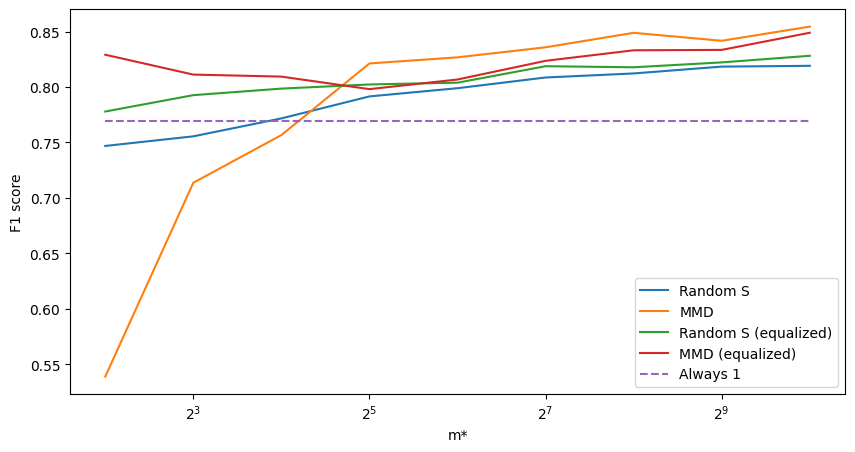

<Figure size 640x480 with 0 Axes>

In [347]:
# Plot x-axis: m-star, y-axis: F1 score
plt.figure(figsize=(10,5))
plt.plot(m_stars, f1_scores_random, label=f"Random S")
plt.plot(m_stars, f1_scores_mmd, label=f"MMD")
# equalized histograms
plt.plot(m_stars, f1_scores_random_eq, label=f"Random S (equalized)")
plt.plot(m_stars, f1_scores_mmd_eq, label=f"MMD (equalized)")
# baseline
plt.plot(m_stars, always_one["f1"]*np.ones_like(m_stars), label="Always 1", linestyle="--")
# set x-axis to log scale
plt.xscale('log', base=2)
plt.legend()
plt.xlabel("m*")
plt.ylabel("F1 score")
plt.show()
plt.savefig("f1_scores.png")

## Balanced Accuracy

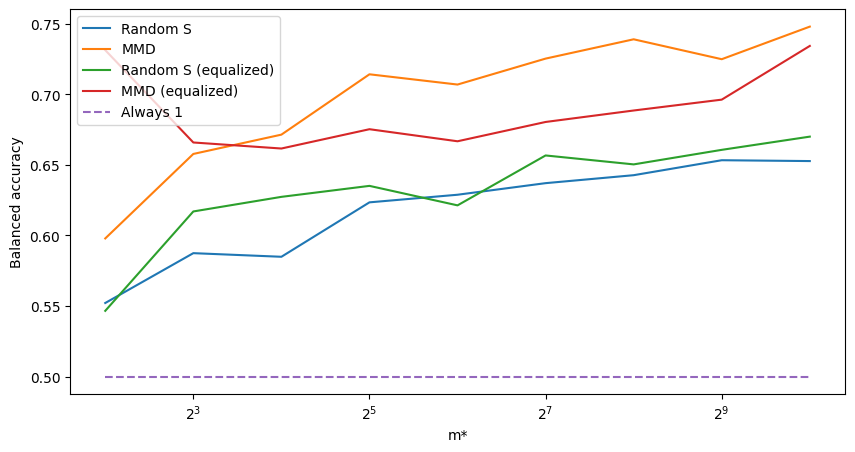

<Figure size 640x480 with 0 Axes>

In [357]:
# Plot x-axis: m-star, y-axis: F1 score
plt.figure(figsize=(10,5))
plt.plot(m_stars, ba_scores_random, label=f"Random S")
plt.plot(m_stars, ba_scores_mmd, label=f"MMD")
# equalized histograms
plt.plot(m_stars, ba_scores_random_eq, label=f"Random S (equalized)")
plt.plot(m_stars, ba_scores_mmd_eq, label=f"MMD (equalized)")
plt.plot(m_stars, always_one["ba"]*np.ones_like(m_stars), label="Always 1", linestyle="--")
# set x-axis to log scale
plt.xscale('log', base=2)
plt.legend()
plt.xlabel("m*")
plt.ylabel("Balanced accuracy")
plt.show()
plt.savefig("challenge_ba_scores.png")

# Prototype Inspection
We plot five positive and five negative prototypes.

In [376]:
# Recompute the best mmd model for 128 prototypes
print(best_gamma, best_local, best_seperate)
mmd_model = MMDPrototypeClassifier(best_gamma, 128, local=best_local)
mmd_model.fit(Xtrain_eq, Ytrain_eq, K=Ks[best_gamma], verbose=False, seperate=best_seperate)
_ = mmd_model.score(Xtest_eq, Ytest_eq, verbose=True)

1e-06 True True
Precision/Recall: 0.73/0.95
F1:  0.82
Acc.: 0.75
Balanced Acc.: 0.68


In [377]:
S_indices = mmd_model.S_indices

In [387]:
positive_indices = np.where(Ytrain_eq[S_indices] == 1)
negative_indices = np.where(Ytrain_eq[S_indices] == 0)
# Sample first 5 positive and 5 negative examples
positive_indices = positive_indices[0][:5]
negative_indices = negative_indices[0][:5]

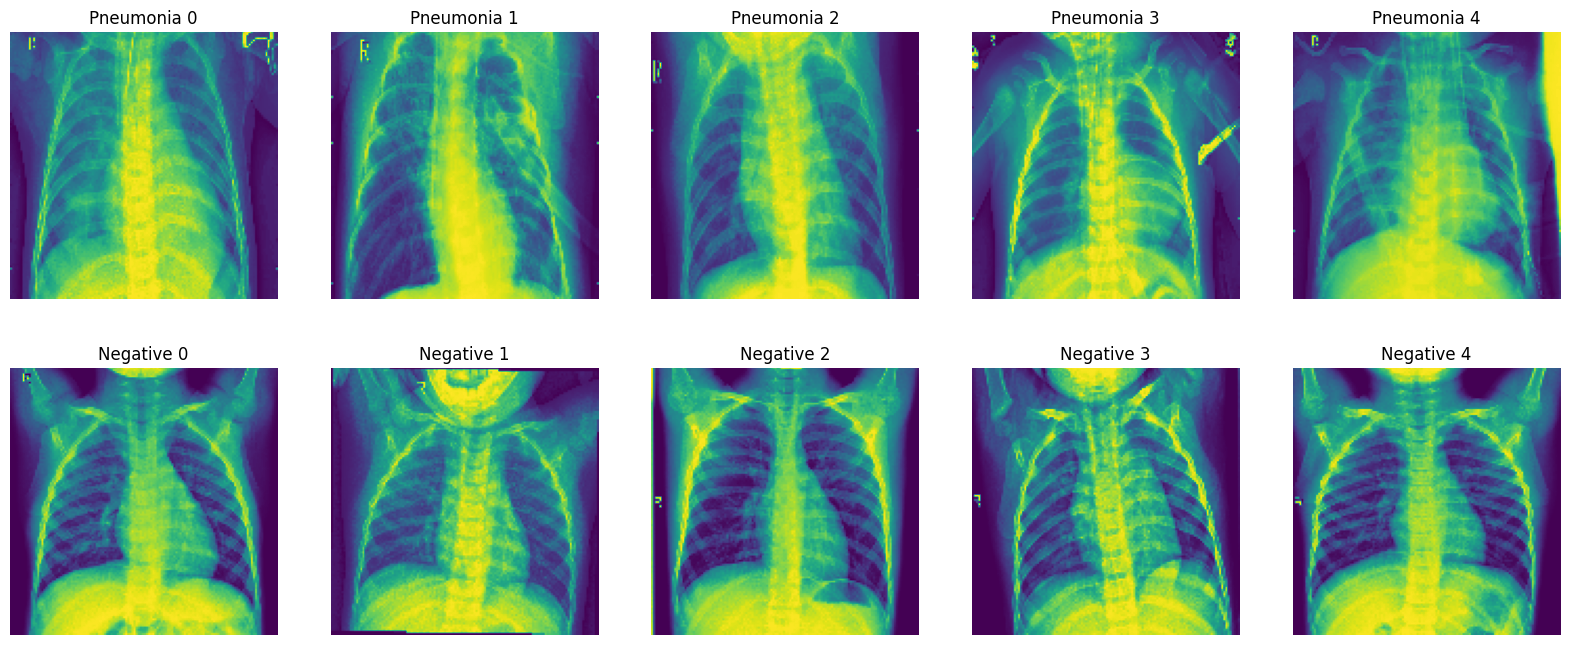

In [396]:
# Plot the examples in two rows
plt.figure(figsize=(20,8))
for i, index in enumerate(positive_indices):
    plt.subplot(2,5,i+1)
    img = inflate(Xtrain_eq[S_indices[index]], 128)
    # unnormalize
    img = img*255
    plot_img(img)
    plt.title(f"Pneumonia {i}")
    plt.axis("off")

for i, index in enumerate(negative_indices):
    plt.subplot(2,5,i+6)
    img = inflate(Xtrain_eq[S_indices[index]], 128)
    # unnormalize
    img = img*255
    plot_img(img)
    plt.title(f"Negative {i}")
    plt.axis("off")